# <font color=40534C size="6.5">**Building a Padang Food Image Similarity Search Engine with FAISS & CLIP**</font>
 

<font color=40534C>**Install & import Requirements**</font>

In [1]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

/Users/yudhypr/University/Compvi/Codex/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font color=40534C size="5.5">**Step 1 - Explore the Data**</font>

<font color=40534C>**Display random images from the dataset:**</font>

Total images found: 967


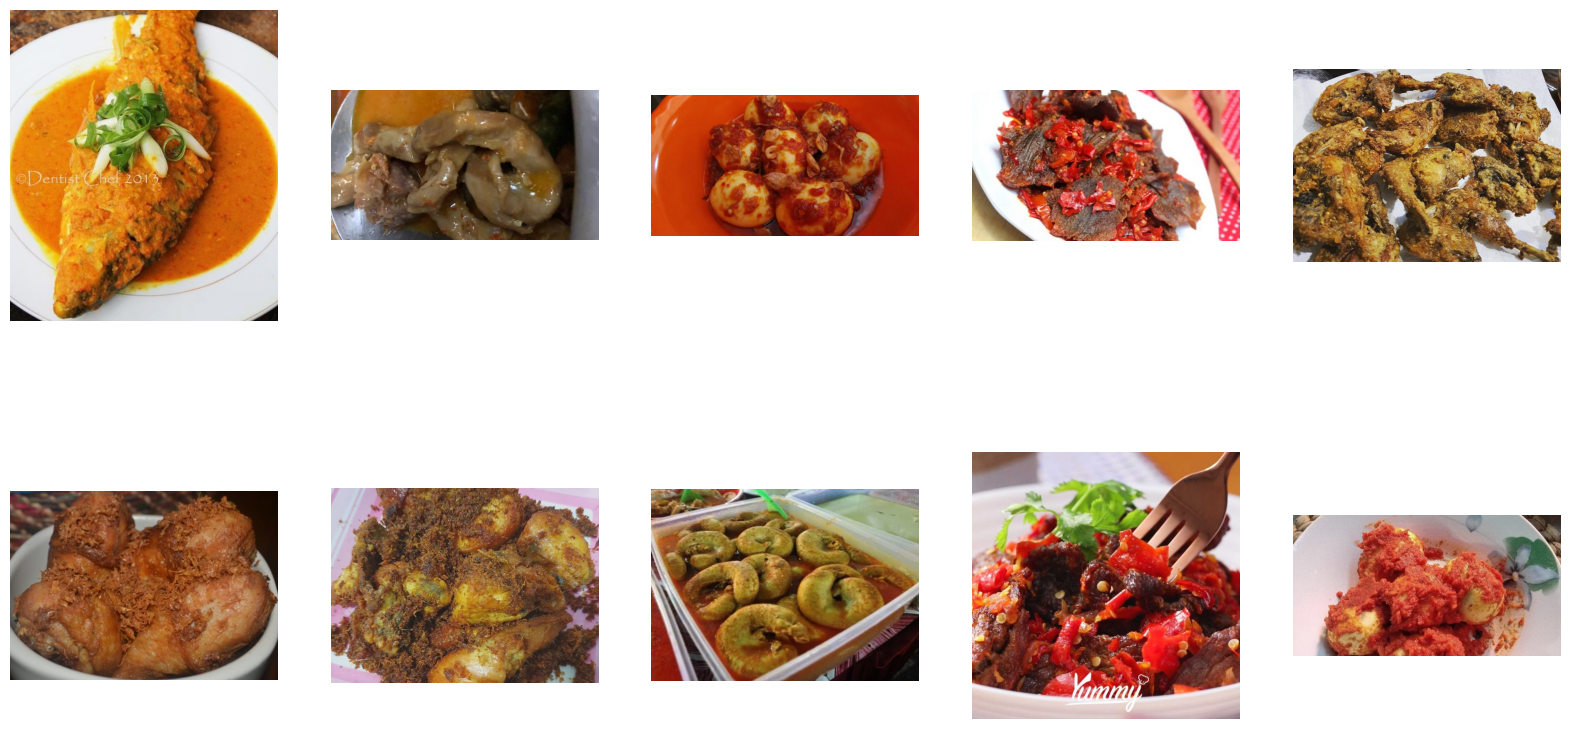

In [2]:
image_folder = '/Users/yudhypr/University/Compvi/Codex/dataset_padang_food'

# Get a list of all image files in the folder
image_files = []
for ext in ('*.jpg', '*.jpeg', '*.png'):
    image_files.extend(glob(os.path.join(image_folder, '**', ext), recursive=True))

print(f"Total images found: {len(image_files)}")

# Randomly select 10 image files
random.seed(42)
selected_images = random.sample(image_files, 10)

# Display the selected images
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

<font color=40534C size="5.5">**Step 2 - Generate CLIP embeddings**</font>

In [3]:
def progress_bar(current: int, total: int):
    """Simple progress indicator."""
    percent = (current / total) * 100
    bar_length = 50
    filled = int(bar_length * current / total)
    bar = "█" * filled + "░" * (bar_length - filled)
    print(f"\rProgress: [{bar}] {percent:.1f}% ({current}/{total})", end="", flush=True)
    if current == total:
        print()  # New line when complete

In [4]:
def generate_clip_embeddings(images_path, model):
    image_paths = []
    for ext in ('*.jpg', '*.jpeg', '*.png'):
        image_paths.extend(glob(os.path.join(images_path, '**', ext), recursive=True))

    print(f"Total images found: {len(image_paths)}")

    embeddings = []
    total = len(image_paths)
    for i, img_path in enumerate(image_paths, 1):
        image = Image.open(img_path)
        embedding = model.encode(image)
        embeddings.append(embedding)
        progress_bar(i, total)

    return embeddings, image_paths


IMAGES_PATH = 'dataset_padang_food'
model = SentenceTransformer('clip-ViT-B-32')
embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH, model)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Total images found: 967
Progress: [██████████████████████████████████████████████████] 100.0% (967/967)


<font color=40534C size="5.5">**Step 3 - Generate FAISS Index with Image Embeddings**</font>

<font color=40534C>**Create and Save FAISS Index:**</font>

In [5]:
def create_faiss_index(embeddings, image_paths, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # Save image paths
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')

    return index


OUTPUT_INDEX_PATH = "db/vector.index"
index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH)

Index created and saved to db/vector.index


<font color=40534C>**Load FAISS index:**</font>

In [6]:
def load_faiss_index(index_path):
    index = faiss.read_index(index_path)
    with open(index_path + '.paths', 'r') as f:
        image_paths = [line.strip() for line in f]
    print(f"Index loaded from {index_path}")
    return index, image_paths

index, image_paths = load_faiss_index(OUTPUT_INDEX_PATH)

Index loaded from db/vector.index


<font color=40534C size="5.5">**Step 4 - Retrieve Images by Text Query or Referance Image**</font>

<font color=40534C>**A function to retrive images with Text or Image query:**</font>

In [7]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):

    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

<font color=40534C>**An helper function to display results:**</font>



In [8]:
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

<font color=40534C>**Search with a Text Query:**</font>

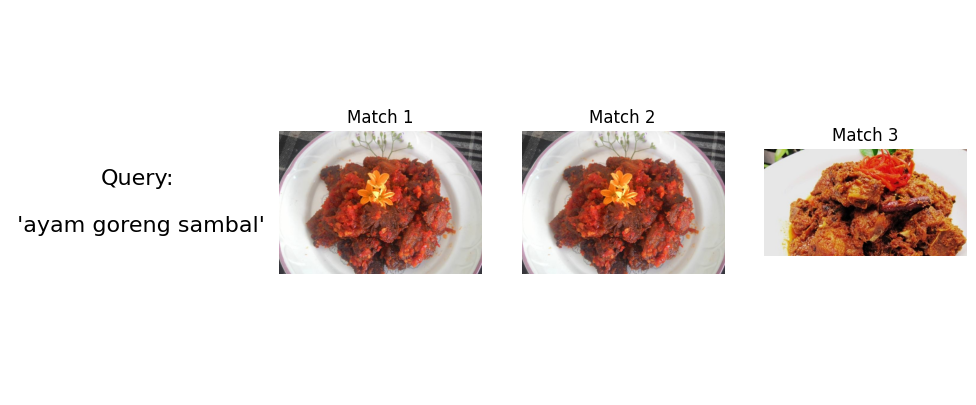

In [14]:
query = 'ayam goreng sambal'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

<font color=40534C>**Search with a Reference Image:**</font>

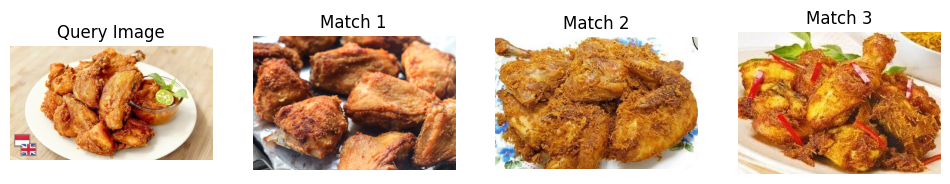

In [16]:
query = 'test/ayam-goreng-biasa.jpg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

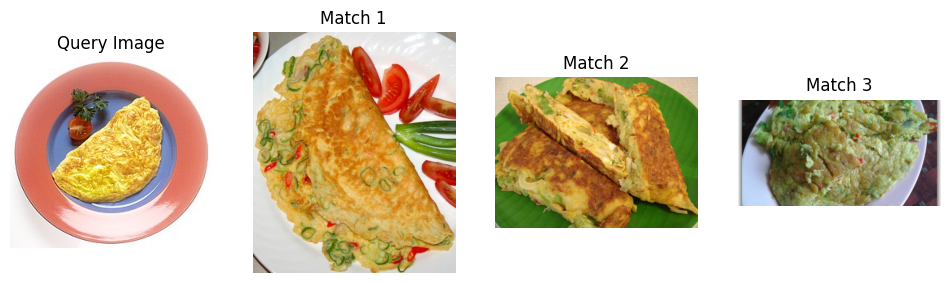

In [30]:
query = 'test/telur-dadar.jpg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

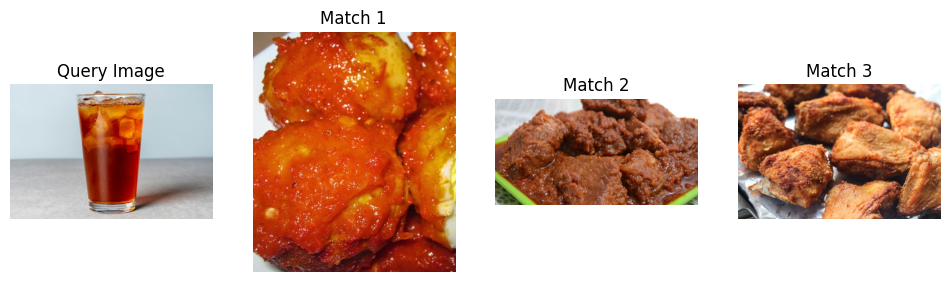

In [31]:
query = 'test/es-tehh.jpg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

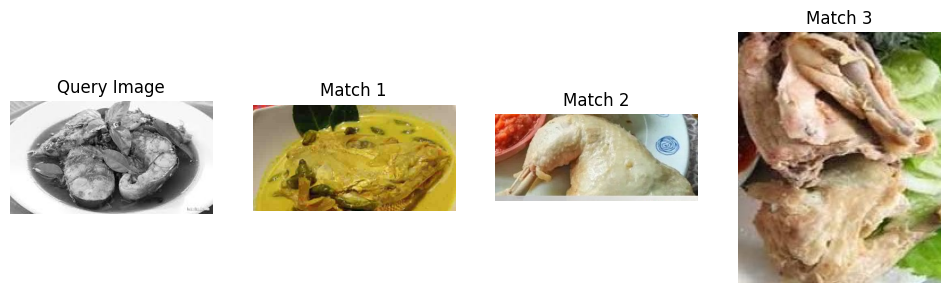

In [32]:
query = 'test/gulai-mono.jpeg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)